# Some time series stuff

Hesitant to use differencing (e.g.  SARIMA) because a lot of information is lost (we don't directly see seasonality, instead we just remove it). Hence we prefer to explicitly remove seasonality. However, SARIMA may be better at avoiding overfitting, see http://people.duke.edu/~rnau/seasarim.htm

In [1]:
import matplotlib.pylab as plt
import matplotlib as m

%matplotlib inline

import pandas as pd
import numpy as np
import pickle as pickle

In [2]:
sept = pickle.load(open('pickles/sept2015_fpl.p', 'rb'))

In [11]:
df = sept
temp = df.groupby([df.index.day, df.index.hour]).agg(
                np.mean
        )

In [12]:
temp.head()

casual   looking  reflecting
1 0  0.011135  0.006202    0.000846
  1  0.007508  0.004880    0.002127
  2  0.008449  0.006499    0.001516
  3  0.000000  0.000000    0.018868
  4  0.009442  0.006979    0.003010

In [13]:
casual = temp.casual
looking = temp.looking
reflecting = temp.reflecting

In [17]:
from plotting.alcohol import ComparisonPlot

In [18]:
ComparisonPlot.formatting()

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


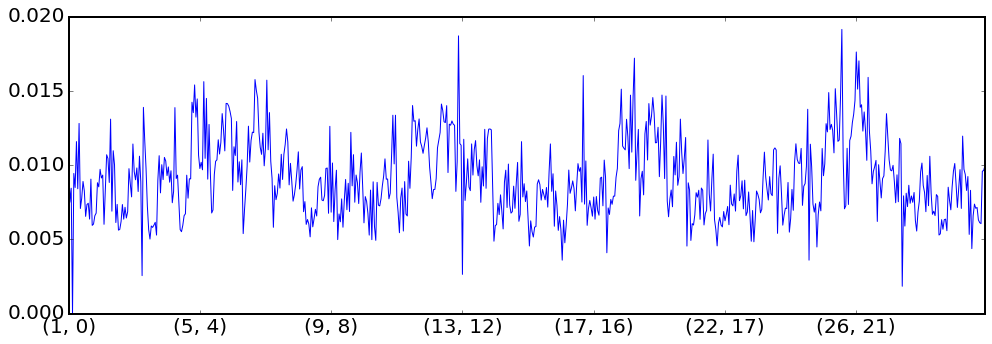

In [47]:
casual.plot()

In [36]:
res = decompose_seasonal(casual, 24)

In [37]:
seasonal = res['seasonal']
deseasoned = res['deseasoned']
trend = res['trend']

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


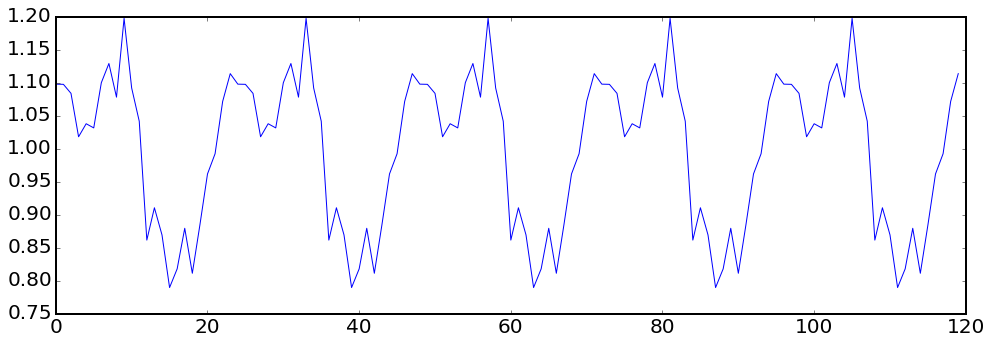

In [38]:
plt.plot(seasonal[:24*5])

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


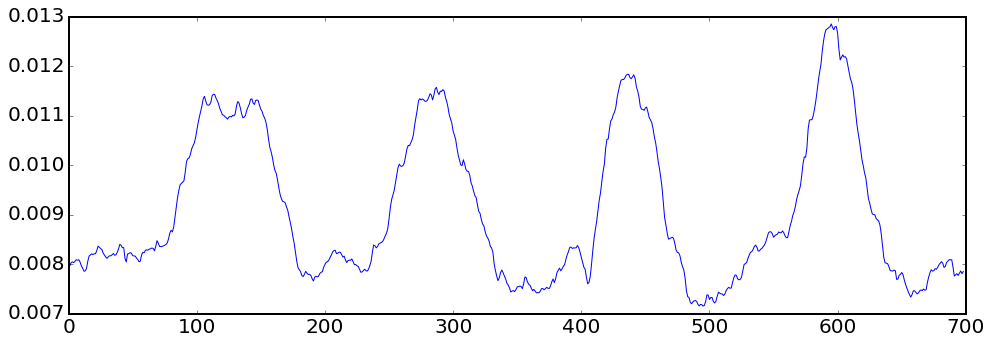

In [39]:
plt.plot(trend)

In [41]:
detrended = deseasoned/trend

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


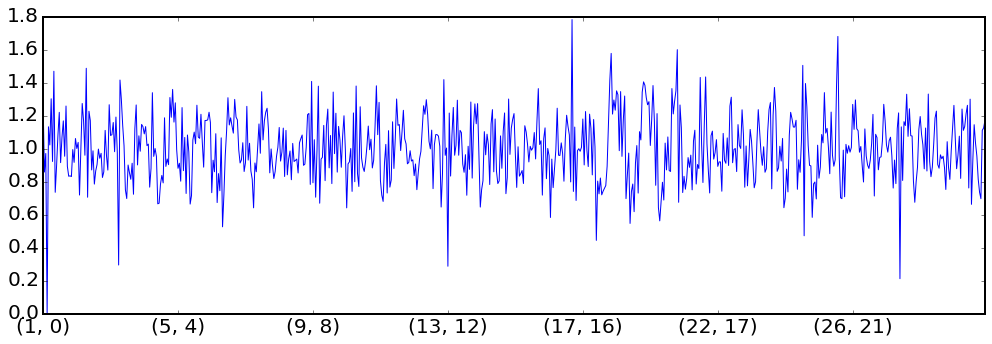

In [42]:
detrended.plot()

<Container object of 41 artists>

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


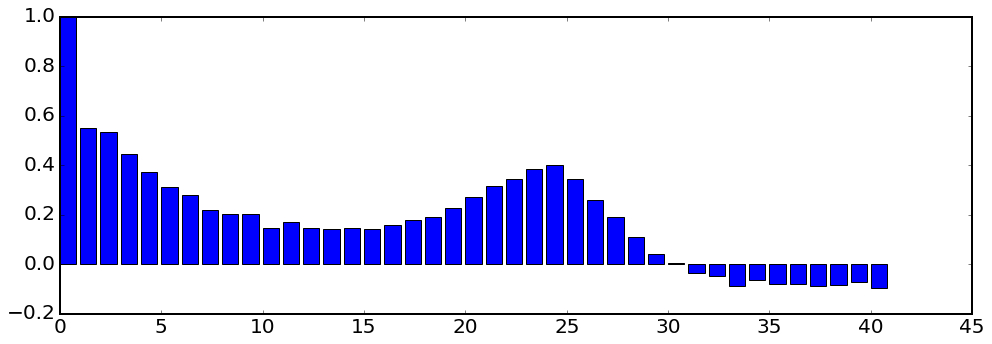

In [67]:
fig, ax = plt.subplots()
acf = sm.tsa.acf(casual)
ax.bar(range(len(acf)), acf)

<Container object of 41 artists>

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


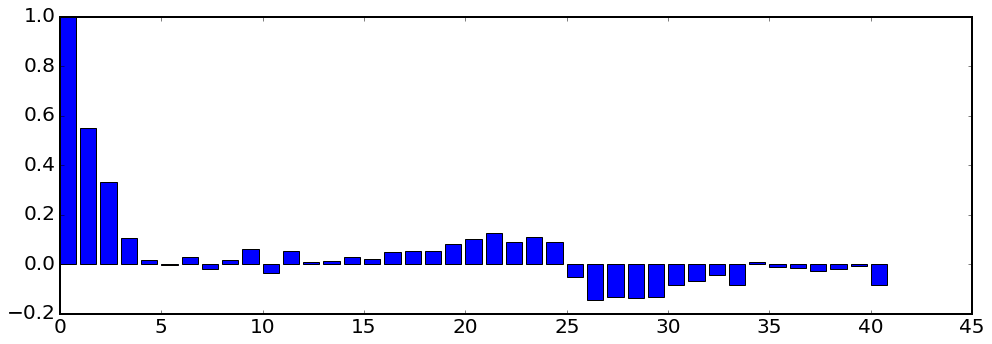

In [68]:
fig, ax = plt.subplots()
pacf = sm.tsa.pacf(casual)
ax.bar(range(len(pacf)), pacf)

C:\Users\Tom Work\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


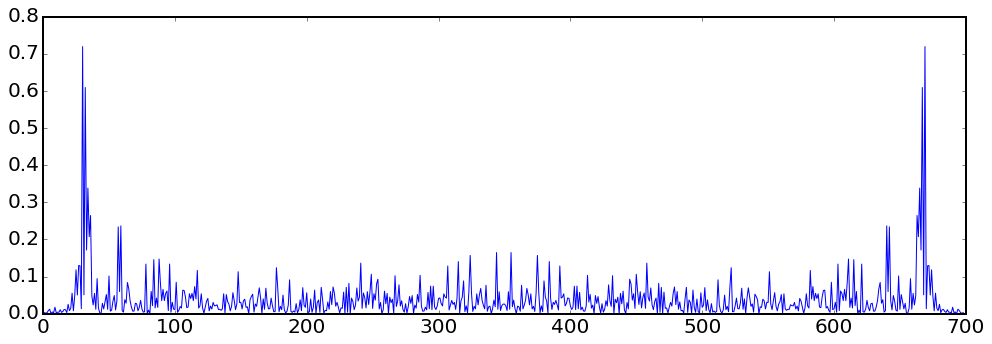

In [62]:
periodogram = sm.tsa.periodogram(detrended)
plt.plot(periodogram)

In [3]:
df_all = pickle.load(open('pickles/June_labeled_updated_fpl.p', 'rb'))

In [6]:
def setup(df):
    p = 0.75
    of_interest = df.predict_fpa > p

    df["first_person_alcohol"] = 0
    df["first_person_alcohol"][of_interest] = 1
    fp_cols = [ 'predict_present', 'predict_future', 'predict_past']
    new_fp_cols = ["casual", "looking", "reflecting"]
    for new_name, old_name in zip(new_fp_cols, fp_cols):
        df[new_name] = df[old_name] >0.6

In [7]:
setup(df_all)

C:\Users\Tom Work\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
week1 = df_all['2015-06-01':'2015-06-07']
week2 = df_all['2015-06-08':'2015-06-14']
week3 = df_all['2015-06-15':'2015-06-21']
week4 = df_all['2015-06-22':'2015-06-28']
week5 = df_all['2015-06-29':]
weeks = [week1, week2, week4]

In [264]:
temp = pd.DataFrame()
fpl = [df_all.casual, df_all.looking, df_all.reflecting]
by_hour = list()
for df in fpl:
    temp = df.groupby([df.index.dayofweek, df.index.hour]).agg(
        'mean'
    )
    by_hour.append(temp)

In [81]:
def cross_corr(ts1, ts2, lag=0):
    return ts1.corr(ts2.shift(lag))

In [175]:
by_hour[0].shape

(24,)

In [88]:
correlogram = [cross_corr(by_hour[0], by_hour[2], lag = i) for i in range(28)]

In [89]:
correlogram

[0.0033272979431857369,
 -0.00030799628860753213,
 0.0045487444935501577,
 0.013908704051362589,
 0.062354758147228781,
 0.11513747282593749,
 0.18735753901246258,
 0.23442860180845981,
 0.28164930380368897,
 0.38115088823079551,
 0.44636813037245981,
 0.52495690937754558,
 0.59851467897017341,
 0.67654546772965329,
 0.68747454998901691,
 0.67125142098435076,
 0.59726503643854267,
 0.49920190593989222,
 0.35670098302778275,
 0.23675955357669834,
 0.12141835317526314,
 0.015324150111422232,
 -0.070147256142134004,
 -0.12450179879798315,
 -0.16775430267852817,
 -0.2184951014349665,
 -0.24698590239740983,
 -0.25048511752817332]

In [98]:
def plot_correlogram(ts1, ts2, max_lag):
    def cross_corr(ts1, ts2, lag=0): return ts1.corr(ts2.shift(lag))
    correlogram = [cross_corr(ts1, ts2, lag = i) for i in range(max_lag)]
    plt.plot(range(max_lag), correlogram)
    plt.xticks(range(0, 24*7, 24))
    plt.grid()

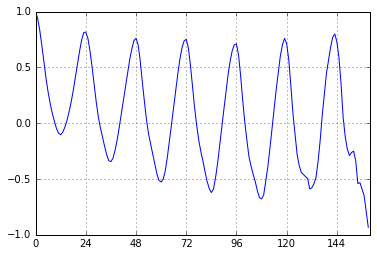

In [101]:
plot_correlogram(by_hour[0], by_hour[0], 160)

In [73]:
from scipy import signal

In [109]:
from statsmodels.tsa import stattools

In [111]:
periodogram = stattools.periodogram(by_hour[0])

In [113]:
help(stattools.periodogram)

Help on function periodogram in module statsmodels.tsa.stattools:

periodogram(X)
    Returns the periodogram for the natural frequency of X
    
    Parameters
    ----------
    X : array-like
        Array for which the periodogram is desired.
    
    Returns
    -------
    pgram : array
        1./len(X) * np.abs(np.fft.fft(X))**2
    
    
    References
    ----------
    Brockwell and Davis.



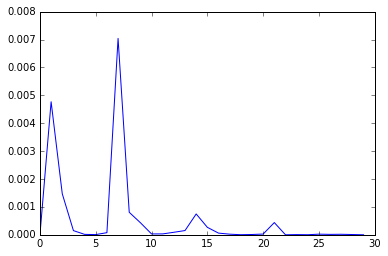

In [121]:
plt.plot(range(len(periodogram[:30])), periodogram[:30])

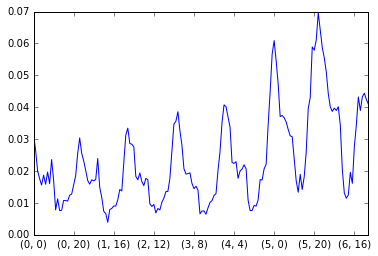

In [265]:
by_hour[0].plot()

# Naive Decomposition

We look at daily seasonality and trend over the week. Moving average trend. We expect there to be an increasing trend over the week, so we should consider some kind of regression (linear, poly). This is preferred over differencing because we want to keep the daily information intact.

Other possible trend estimation: exponential, FFT to remove high freq.

Harmonic regression for season

In [23]:
import statsmodels.api as sm

In [165]:
help(sm.tsa.seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None)
    Parameters
    ----------
    x : array-like
        Time series
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The default is a symmetric moving average.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas
        object with a timeseries index.
    
    Returns
    -------
    results : obj
        A object with seasonal, trend, and resid attributes.
    
    Notes
    -----
    This is a naive decomposition. More sophisticated methods should
    be preferred.
    
    The additive model is Y[t] = T[t] + S[t] + e[t]
    
    The multiplicative model is Y[t] = T[t] * S[t] * e[t]
    
    The seasonal component is first removed by applying a con

A multiplicative model makes more sense here (can be confirmed by plotting an additive decomposition which looks bad)

Consider HP filter in future

In [353]:
# res = sm.tsa.seasonal_decompose(by_hour[0].values, freq=24)
res = sm.tsa.seasonal_decompose(by_hour[0].values, model='multiplicative', freq=24)

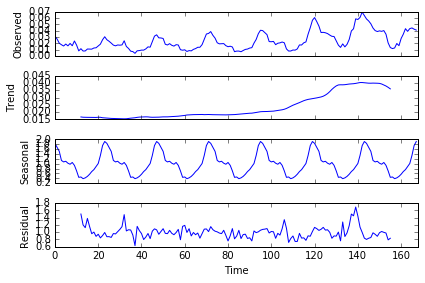

In [354]:
resplot = res.plot()

In [279]:
res.seasonal.shape

(168,)

# Residuals over 3 weeks:

In [324]:
df = pd.concat([week1.casual, week2.casual ,week4.casual])
casual =  df.groupby([df.index.day, df.index.hour]).agg(
        'mean'
    )

In [318]:
trend_mult = np.array(res.trend)
# trend_mult[np.isnan(res.trend)] = np.nanmean(trend_mult)
trend_mult

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.01671059,  0.01651594,  0.01644857,
        0.01644037,  0.01643406,  0.01640962,  0.01640103,  0.01637403,
        0.01648993,  0.01647321,  0.01618049,  0.01605989,  0.01595369,
        0.01578037,  0.01570887,  0.0156616 ,  0.01557444,  0.01550669,
        0.01544414,  0.01544444,  0.01543452,  0.0154798 ,  0.01568555,
        0.0158701 ,  0.0159972 ,  0.01616975,  0.01643263,  0.0166131 ,
        0.01666836,  0.01674153,  0.01678213,  0.01673778,  0.01656822,
        0.01648792,  0.01649424,  0.01648296,  0.01657425,  0.01669539,
        0.01676385,  0.01676089,  0.01677537,  0.01685148,  0.01695651,
        0.01699695,  0.01706814,  0.01723157,  0.01738198,  0.0174987 ,
        0.01775204,  0.01804722,  0.01814609,  0.01820806,  0.01829627,
        0.01832943,  0.01838189,  0.01845372,  0.01840116,  0.01

In [20]:
import statsmodels.tsa as tsa

In [21]:
def decompose_seasonal(ts, period):
    # ma to detrend
    
    # cyclic ma
    x = np.tile(ts, 3)
    if period % 2 == 0:  # split weights at ends
        filt = np.array([.5] + [1] * (period - 1) + [.5]) / period
    else:
        filt = np.repeat(1./period, period)
    trend = sm.tsa.filters.convolution_filter(x, filt, nsides=2)
    
    nobs = len(ts)
    detrended = (x / trend)[nobs: -nobs]
    
    # seasonal average
    seasonal = np.tile(np.array([np.mean(detrended[i::period]) for i in range(period)]), nobs//period + 1)[:nobs]
    deseasoned = ts/seasonal
    return {'seasonal': seasonal, 'deseasoned': deseasoned, 'trend': trend[nobs:-nobs]}

In [438]:
result = decompose_seasonal(by_hour[0], 24)
seasonal = result['seasonal']
deseasoned = result['deseasoned']
trend = result['trend']

(168,) (168,) (504,)


In [416]:
seasonal-res.seasonal

array([-0.08857581, -0.09240582, -0.10352145, -0.06151956, -0.06302446,
       -0.04410534, -0.04505612, -0.0066138 , -0.03622909,  0.04648519,
        0.036019  ,  0.00162065, -0.0188553 , -0.00287015,  0.02566762,
        0.00431805,  0.04833293,  0.07001489,  0.10794302,  0.07461174,
        0.08674569,  0.05126506, -0.0160696 , -0.04699156, -0.08857581,
       -0.09240582, -0.10352145, -0.06151956, -0.06302446, -0.04410534,
       -0.04505612, -0.0066138 , -0.03622909,  0.04648519,  0.036019  ,
        0.00162065, -0.0188553 , -0.00287015,  0.02566762,  0.00431805,
        0.04833293,  0.07001489,  0.10794302,  0.07461174,  0.08674569,
        0.05126506, -0.0160696 , -0.04699156, -0.08857581, -0.09240582,
       -0.10352145, -0.06151956, -0.06302446, -0.04410534, -0.04505612,
       -0.0066138 , -0.03622909,  0.04648519,  0.036019  ,  0.00162065,
       -0.0188553 , -0.00287015,  0.02566762,  0.00431805,  0.04833293,
        0.07001489,  0.10794302,  0.07461174,  0.08674569,  0.05

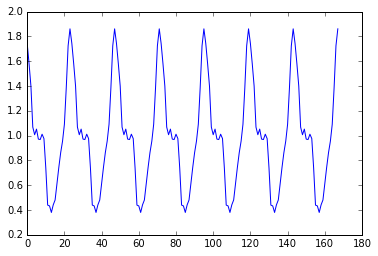

In [417]:
plt.plot(seasonal)

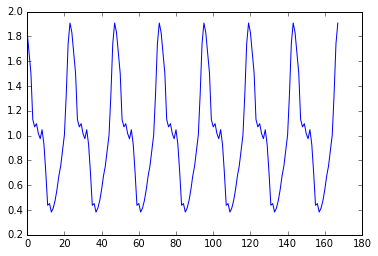

In [418]:
plt.plot(res.seasonal)

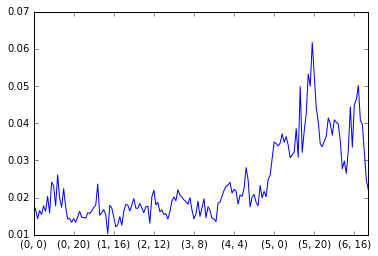

In [422]:
deseasoned.plot()

Linear regression detrend

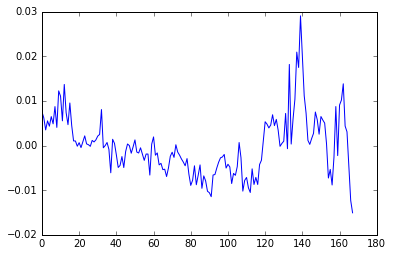

In [425]:
no_trend = tsa.tsatools.detrend(deseasoned)
plt.plot(no_trend)

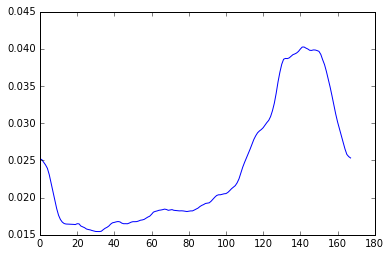

In [465]:
plt.plot(trend)

In [442]:
detrended = deseasoned/trend

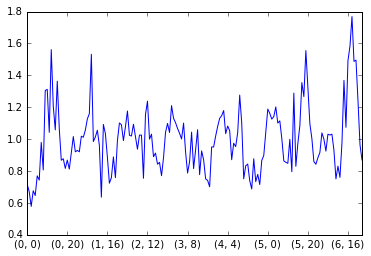

In [444]:
detrended.plot()

In [518]:
errs = (casual.values/np.tile(seasonal, 3))/np.tile(trend, 3)

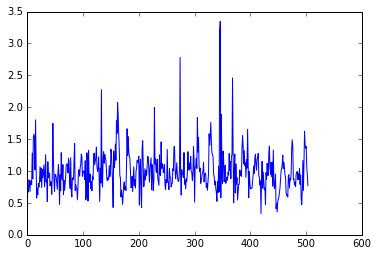

In [531]:
plt.plot(errs)

In [507]:
import math

In [511]:
vlog = np.vectorize(math.log)

In [533]:
log_errs = vlog(errs)

In [534]:
log_errs

array([ -1.92225201e-01,  -3.68537710e-01,  -4.02904956e-01,
        -1.49605381e-01,  -1.79314841e-01,  -3.87479977e-01,
        -1.96210691e-01,  -1.61595120e-01,  -2.39673586e-01,
         2.47871668e-01,  -1.32006505e-01,   4.25030779e-01,
         4.56320782e-01,   4.19606967e-01,   1.88080450e-02,
         5.88746165e-01,   4.62321363e-02,  -5.50161959e-01,
        -3.12707024e-01,  -4.61942884e-01,  -2.18486426e-01,
        -2.90222970e-01,  -1.97135658e-01,   6.43894789e-02,
        -1.80483430e-01,   4.56661187e-02,  -3.00687909e-01,
         2.31112634e-02,  -1.10187832e-01,   5.35690696e-03,
         9.07251132e-02,  -2.82915707e-01,  -1.09166321e-01,
         2.28561497e-01,  -1.90910935e-01,  -1.38035953e-01,
        -6.51612831e-01,   1.36384737e-01,  -1.13004604e-01,
        -4.62962633e-02,  -3.11985470e-02,  -2.66327102e-01,
        -1.82010783e-01,  -1.92096757e-01,  -4.53050365e-01,
        -4.98213103e-02,   5.58311788e-01,   1.70592560e-01,
        -1.79526731e-01,

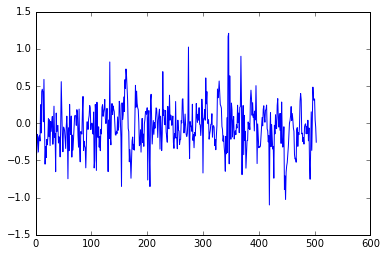

In [536]:
plt.plot(log_errs)

In [537]:
log_errs.mean()

-0.047503760376224183

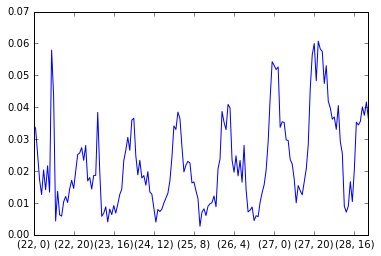

In [473]:
casual.ix[22:28].plot()

In [503]:
week4cas = week4[week4.casual]
day22 = week4cas[week4cas.index.day == 22]
(day22.index.hour > 8) and (day22.index.hour < 12)

array([False, False, False, ...,  True,  True,  True], dtype=bool)